## Importing Packages & Loading the Data

In [1]:
#importing packages

import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import folium

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#!pip install fbprophet

In [3]:
#read in all datasets

#median rent asking price for studio, 1br and 3br+
rent_studio = pd.read_csv('csvs/medianAskingRent_Studio.csv')
rent_1br = pd.read_csv('csvs/medianAskingRent_OneBd.csv')
rent_3br_plus = pd.read_csv('csvs/medianAskingRent_ThreePlusBd.csv')

#inventory for studio, 1br and 3br+
inv_studio = pd.read_csv('csvs/rentalInventory_Studio.csv')
inv_1br = pd.read_csv('csvs/rentalInventory_OneBd.csv')
inv_3br_plus = pd.read_csv('csvs/rentalInventory_ThreePlusBd.csv')

In [4]:
#We'll be using rent data from 2015 to May 2020

#rent_studio.head(3)

In [5]:
#transpose dataset, rename columns, change index to datetime object

#studio
studio_df = rent_studio.T
studio_df.columns = rent_studio.iloc[:,0]
studio_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
studio_df.index = pd.to_datetime(studio_df.index)

#1br
onebr_df = rent_1br.T
onebr_df.columns = rent_1br.iloc[:,0]
onebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
onebr_df.index = pd.to_datetime(onebr_df.index)

#3br+
threebr_df = rent_3br_plus.T
threebr_df.columns = rent_3br_plus.iloc[:,0]
threebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
threebr_df.index = pd.to_datetime(threebr_df.index)

Neighborhoods:

- Astoria
- Greenpoint
- Woodside

In [6]:
#filter dataframes | we only want 2015-2020 rental data of the three neighborhoods mentioned above

agw_studios = studio_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_1br = onebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_3br = threebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]

## Greenpoint

In [7]:
greenpoint_map = folium.Map(location=[40.7305, -73.9515], zoom_start=15)

In [8]:
greenpoint_map

### Studios

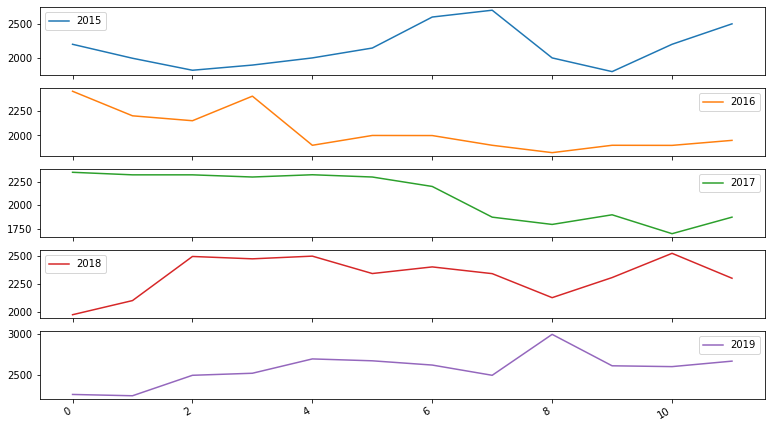

In [9]:
# Use pandas grouper to group values using annual frequency
year_groups_g = agw_studios['2015':'2019'][['Greenpoint']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
studios_annual_g = pd.DataFrame()

for yr, group in year_groups_g:
    studios_annual_g[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_g.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [10]:
roll_mean_g = agw_studios[['Greenpoint']].rolling(window=8, center=False).mean()
roll_std_g = agw_studios[['Greenpoint']].rolling(window=8, center=False).std()

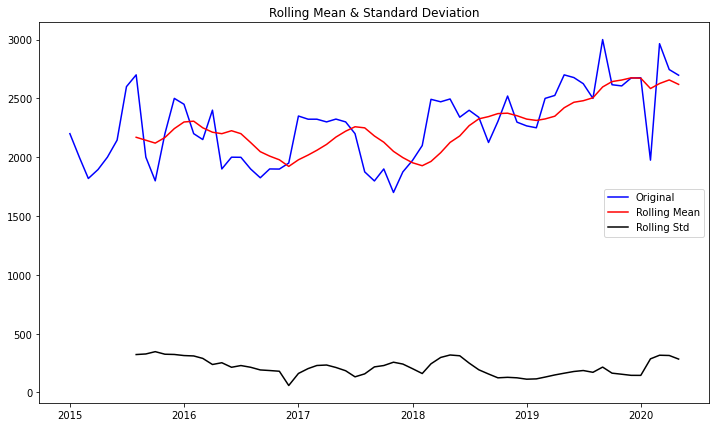

In [11]:
fig = plt.figure(figsize=(12,7))
plt.plot(agw_studios[['Greenpoint']], color='blue', label='Original')
plt.plot(roll_mean_g, color='red', label='Rolling Mean')
plt.plot(roll_std_g, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [13]:
#dickeyfuller test for Sunnyside Studios

dftest_g = adfuller(agw_studios[['Greenpoint']])

# Extract and display test results in a user friendly manner
dfoutput_g = pd.Series(dftest_g[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_g[4].items():
    dfoutput_g['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_g)

Results of Dickey-Fuller test: 

Test Statistic                 -2.845670
p-value                         0.052040
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [ ]:
#not stationary

### ACF & PACF

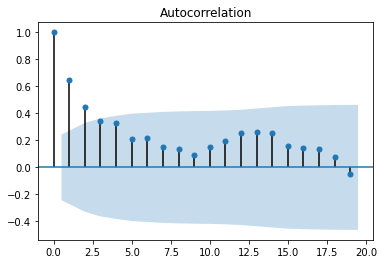

In [82]:
plot_acf(agw_studios['Greenpoint']);

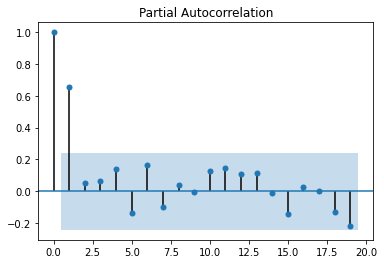

In [83]:
plot_pacf(agw_studios['Greenpoint']);

## BASELINE MODEL

In [16]:
#Base

green_studios = agw_studios[['Greenpoint']]

In [17]:
# Create lagged dataset
values = pd.DataFrame(green_studios.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

    t-1   t+1
0   NaN  2200
1  2200  1995
2  1995  1819
3  1819  1895
4  1895  2000


In [18]:
# split into train and test sets
X_base = dataframe.values
train_size = int(len(X_base) * 0.75)
train, test = X_base[1:train_size], X_base[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [19]:
# persistence model
def model_persistence(x):
    return x

In [20]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 346.133


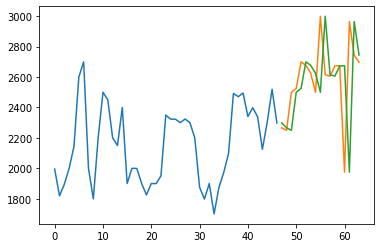

In [21]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

In [ ]:
#score of 346 for base 

## ARIMA MODEL

predicted=2198.550420, expected=2266.000000
predicted=2242.001206, expected=2250.000000
predicted=2241.535051, expected=2500.000000
predicted=2462.095884, expected=2525.000000
predicted=2421.661175, expected=2700.000000
predicted=2582.830893, expected=2677.000000
predicted=2531.766532, expected=2625.000000
predicted=2507.967840, expected=2500.000000
predicted=2421.293492, expected=3000.000000
predicted=2954.477193, expected=2616.000000
predicted=2486.128239, expected=2606.000000
predicted=2556.319824, expected=2673.000000
predicted=2619.031663, expected=2675.000000
predicted=2618.544210, expected=1975.000000
predicted=2074.594725, expected=2965.000000
predicted=2772.650374, expected=2745.000000
predicted=2663.502732, expected=2697.000000
Test RMSE: 330.767


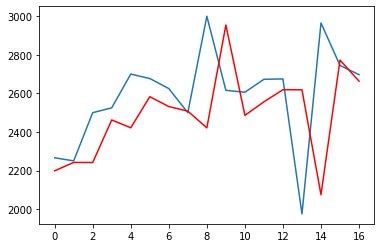

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   63
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -432.757
Method:                       css-mle   S.D. of innovations            227.266
Date:                Sun, 28 Jun 2020   AIC                            875.515
Time:                        11:55:03   BIC                            886.230
Sample:                             1   HQIC                           879.729
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0952      3.038      2.994      0.003       3.141      15.050
ar.L1.D.y      0.5182      0.127      4.087      0.000       0.270       0.767
ar.L2.D.y     -0.0005      0.129     -0.004      0.9

In [25]:
#ARIMA model

X_rima = agw_studios[['Greenpoint']].values
size = int(len(X_rima) * 0.75)
train, test = X_rima[0:size], X_rima[size:len(X_rima)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
print(model_fit.summary())

In [ ]:
#330 score for ARIMA beating base

## FB PROPHET

In [26]:
fb_green = green_studios

In [27]:
fb_green.reset_index(inplace=True)
fb_green.index.rename('', inplace=True)
fb_green.rename(columns={'index': 'ds', 'Greenpoint': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [28]:
fb_green.head()

areaName,ds,y
,,
0,2015-01-01,2200
1,2015-02-01,1995
2,2015-03-01,1819
3,2015-04-01,1895
4,2015-05-01,2000


In [30]:
# Train/Split

X_g_studios = fb_green['ds'].values
y_g_studios = fb_green['y'].values

X_train = X_g_studios[:int(X_g_studios.shape[0]*0.75)]
X_test = X_g_studios[int(X_g_studios.shape[0]*0.75):]
y_train = y_g_studios[:int(X_g_studios.shape[0]*0.75)]
y_test = y_g_studios[int(X_g_studios.shape[0]*0.75):]

g_studio_train = pd.DataFrame(y_train,index = X_train, columns = ['y'])
g_studio_test = pd.DataFrame(y_test, index = X_test, columns = ['y'])
g_studio_train.head()
g_studio_train.reset_index(inplace = True)
g_studio_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  408.2179965060082


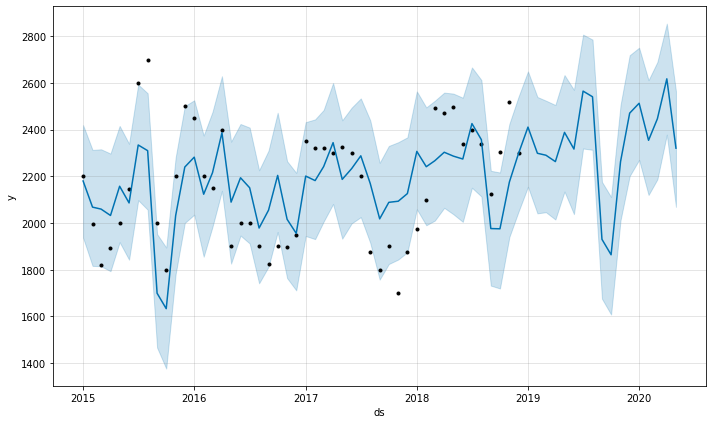

In [32]:
g_studios_prophet = Prophet().fit(g_studio_train)

future_g_studios = g_studios_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_g_studios = g_studios_prophet.predict(future_g_studios)
forecast_g_studios.tail()

fig1_g_studios = g_studios_prophet.plot(forecast_g_studios)

preds_g_studios = forecast_g_studios[48:][['ds','yhat']].set_index('ds')
preds_g_studios.head()

preds_g_studios_df = pd.concat([g_studio_test ,preds_g_studios],axis = 1)
preds_g_studios_df.head()

error = np.sqrt(sum((preds_g_studios_df['y'] - preds_g_studios_df['yhat'])**2)/len(preds_g_studios_df))
print('RMSE in $$: ', error)

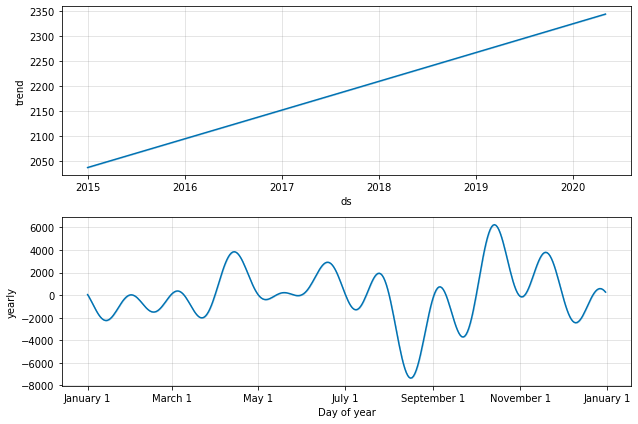

In [33]:
fig2_g_studios = g_studios_prophet.plot_components(forecast_g_studios)

In [ ]:
#408 for FB prophet, not beating the other two

### One Bedroom Aparments

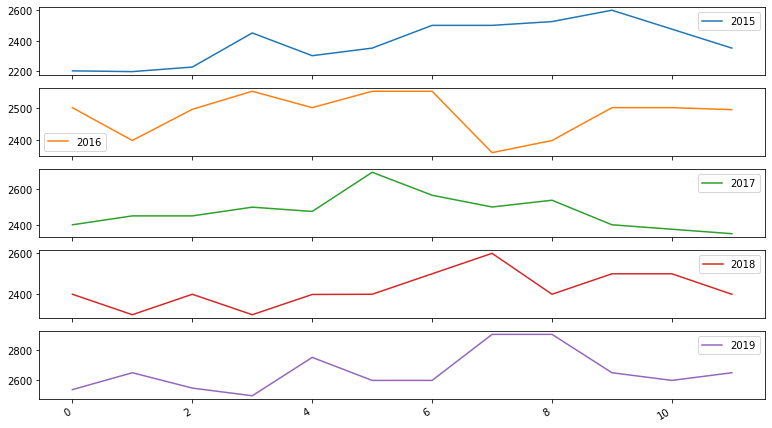

In [34]:
# Use pandas grouper to group values using annual frequency
year_groups_g_1br = agw_1br['2015':'2019'][['Greenpoint']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
annual_g_1br = pd.DataFrame()

for yr, group in year_groups_g_1br:
    annual_g_1br[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
annual_g_1br.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [35]:
roll_mean_g_1br = agw_1br[['Greenpoint']].rolling(window=8, center=False).mean()
roll_std_g_1br = agw_1br[['Greenpoint']].rolling(window=8, center=False).std()

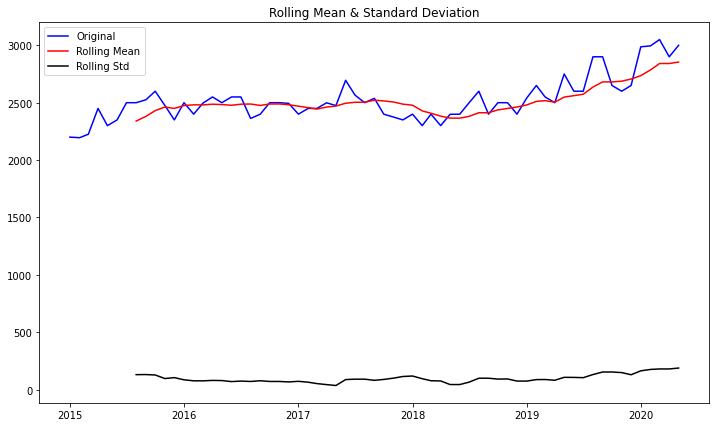

In [36]:
fig_roll_1br = plt.figure(figsize=(12,7))
plt.plot(agw_1br[['Greenpoint']], color='blue', label='Original')
plt.plot(roll_mean_g_1br, color='red', label='Rolling Mean')
plt.plot(roll_std_g_1br, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [37]:
#dickeyfuller test for Astoria Studios

dftest_g_1br = adfuller(agw_1br[['Greenpoint']])

# Extract and display test results in a user friendly manner
dfoutput_g_1br = pd.Series(dftest_g_1br[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_g_1br[4].items():
    dfoutput_g_1br['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_g_1br)

Results of Dickey-Fuller test: 

Test Statistic                 -0.940304
p-value                         0.774410
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [ ]:
#not stationary

### ACF & PACF

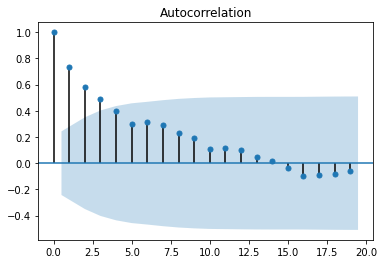

In [38]:
plot_acf(agw_1br['Greenpoint']);

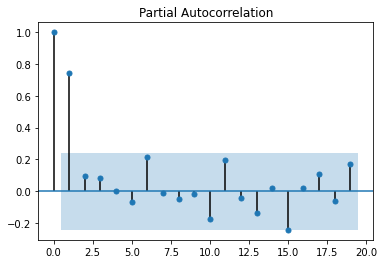

In [39]:
plot_pacf(agw_1br['Greenpoint']);

### BASELINE MODEL

In [40]:
g_1br = agw_1br[['Greenpoint']]

In [41]:
# Create lagged dataset
values_1br = pd.DataFrame(g_1br.values)
dataframe_1br = pd.concat([values_1br.shift(1), values_1br], axis=1)
dataframe_1br.columns = ['t-1', 't+1']
print(dataframe_1br.head(5))

    t-1   t+1
0   NaN  2200
1  2200  2195
2  2195  2225
3  2225  2450
4  2450  2300


In [42]:
# split into train and test sets
X_1br = dataframe_1br.values
train_size_1br = int(len(X_1br) * 0.75)
train_1br, test_1br = X_1br[1:train_size_1br], X_1br[train_size_1br:]
train_X_1br, train_y_1br = train_1br[:,0], train_1br[:,1]
test_X_1br, test_y_1br = test_1br[:,0], test_1br[:,1]

In [43]:
#model persistence defined above in studios

# walk-forward validation
predictions_1br = list()
for x in test_X_1br:
    yhat_1br = model_persistence(x)
    predictions_1br.append(yhat_1br)
test_score = mean_squared_error(test_y_1br, predictions_1br)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 160.121


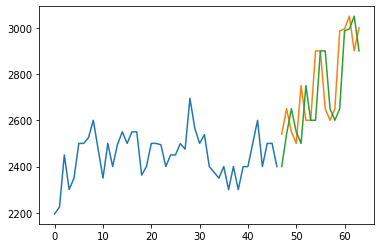

In [44]:
# plot predictions and expected results
plt.plot(train_y_1br)
plt.plot([None for i in train_y_1br] + [x for x in test_y_1br])
plt.plot([None for i in train_y_1br] + [x for x in predictions_1br])
plt.show()

In [ ]:
#160 base score

### ARIMA MODEL

predicted=2470.054267, expected=2540.000000
predicted=2470.054267, expected=2650.000000
predicted=2470.054267, expected=2550.000000
predicted=2470.054267, expected=2500.000000
predicted=2470.054267, expected=2750.000000
predicted=2470.054267, expected=2600.000000
predicted=2470.054267, expected=2600.000000
predicted=2470.054267, expected=2900.000000
predicted=2470.054267, expected=2900.000000
predicted=2470.054267, expected=2650.000000
predicted=2470.054267, expected=2600.000000
predicted=2470.054267, expected=2650.000000
predicted=2470.054267, expected=2987.000000
predicted=2470.054267, expected=2995.000000
predicted=2470.054267, expected=3050.000000
predicted=2470.054267, expected=2900.000000
predicted=2470.054267, expected=3000.000000
Test RMSE: 338.933


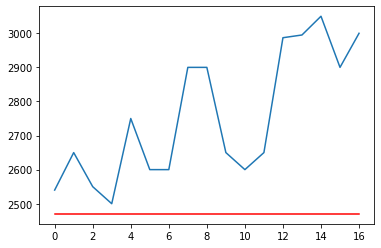

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   47
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -277.382
Method:                       css-mle   S.D. of innovations             88.166
Date:                Sun, 28 Jun 2020   AIC                            566.765
Time:                        12:01:43   BIC                            577.866
Sample:                             1   HQIC                           570.942
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7318      8.991      0.637      0.524     -11.891      23.354
ar.L1.D.y     -0.5737      0.523     -1.098      0.272      -1.598       0.451
ar.L2.D.y     -0.2255      0.283     -0.796      0.4

In [50]:
#ARIMA model

X_rima_1br = agw_1br[['Greenpoint']].values
size_1br = int(len(X_rima_1br) * 0.75)
train_rima_1br, test_rima_1br = X_rima_1br[0:size], X_rima_1br[size:len(X_rima_1br)]
history_rima_1br = [x for x in train_rima_1br]
predictions_rima_1br = list()
for t in range(len(test_rima_1br)):
    model_1br = ARIMA(history_rima_1br, order=(3,1,1))
    model_fit_1br = model_1br.fit(disp=0)
    output = model_fit_1br.forecast()
    yhat = output[0]
    predictions_rima_1br.append(yhat)
    obs = test_rima_1br[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error_1br = mean_squared_error(test_rima_1br, predictions_rima_1br)
print('Test RMSE: %.3f' % sqrt(error_1br))
# plot
plt.plot(test_rima_1br)
plt.plot(predictions_rima_1br, color='red')
plt.show()
print(model_fit_1br.summary())

In [ ]:
#338 ARIMA score, way higher than base 

## FB PROPHET

In [52]:
fb_g_1br = g_1br

In [53]:
fb_g_1br.reset_index(inplace=True)
fb_g_1br.index.rename('', inplace=True)
fb_g_1br.rename(columns={'index': 'ds', 'Greenpoint': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [54]:
fb_g_1br.head(1)

areaName,ds,y
,,
0,2015-01-01,2200


In [55]:
# Train/Split

X_g_1br = fb_g_1br['ds'].values
y_g_1br = fb_g_1br['y'].values

X_train_1br = X_g_1br[:int(X_g_1br.shape[0]*0.75)]
X_test_1br = X_g_1br[int(X_g_1br.shape[0]*0.75):]
y_train_1br = y_g_1br[:int(X_g_1br.shape[0]*0.75)]
y_test_1br = y_g_1br[int(X_g_1br.shape[0]*0.75):]

g_1br_train = pd.DataFrame(y_train_1br,index = X_train_1br, columns = ['y'])
g_1br_test = pd.DataFrame(y_test_1br, index = X_test_1br, columns = ['y'])
g_1br_train.head()
g_1br_train.reset_index(inplace = True)
g_1br_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  413.74774099138597


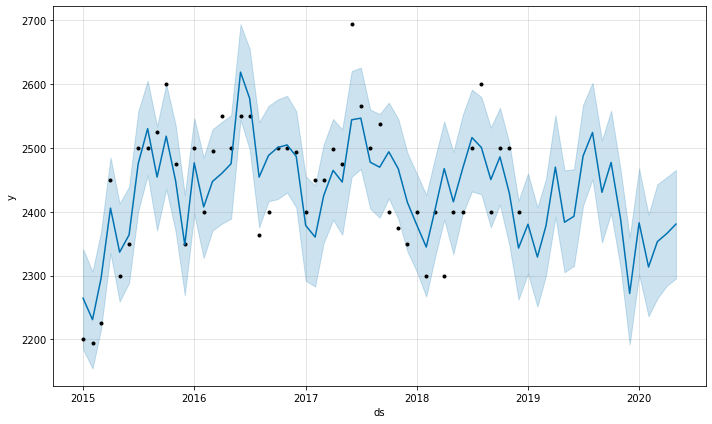

In [56]:
g_1br_prophet = Prophet().fit(g_1br_train)

future_g_1br = g_1br_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_g_1br = g_1br_prophet.predict(future_g_1br)
forecast_g_1br.tail()

fig1_g_1br = g_1br_prophet.plot(forecast_g_1br)

preds_g_1br = forecast_g_1br[48:][['ds','yhat']].set_index('ds')
preds_g_1br.head()

preds_g_1br_df = pd.concat([g_1br_test ,preds_g_1br],axis = 1)
preds_g_1br_df.head()

error_prophet_1br = np.sqrt(sum((preds_g_1br_df['y'] - preds_g_1br_df['yhat'])**2)/len(preds_g_1br_df))
print('RMSE in $$: ', error_prophet_1br)


In [ ]:
#413 - does not beat base and ARIMA

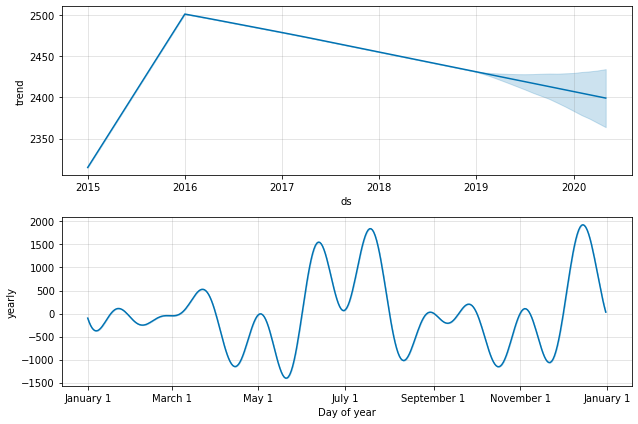

In [57]:
fig2_g_1br = g_1br_prophet.plot_components(forecast_g_1br)

###  Three Bedroom Aparments + 

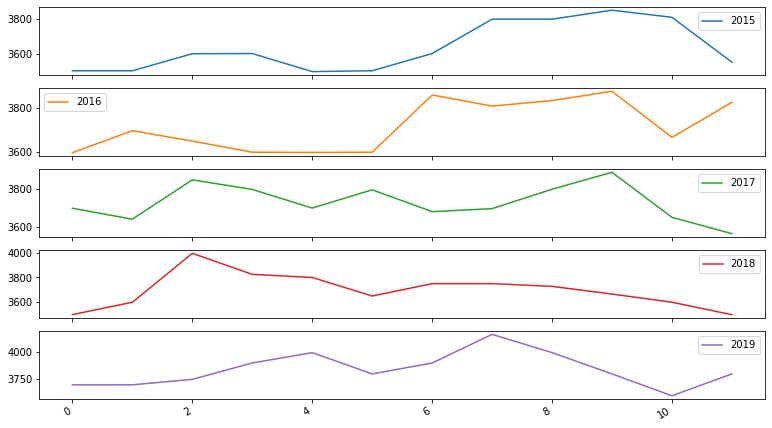

In [58]:
# Use pandas grouper to group values using annual frequency
year_groups_g_3br = agw_3br['2015':'2019'][['Greenpoint']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
annual_g_3br = pd.DataFrame()

for yr, group in year_groups_g_3br:
    annual_g_3br[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
annual_g_3br.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#annual_a_3br.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [59]:
roll_mean_g_3br = agw_3br[['Greenpoint']].rolling(window=8, center=False).mean()
roll_std_g_3br = agw_3br[['Greenpoint']].rolling(window=8, center=False).std()

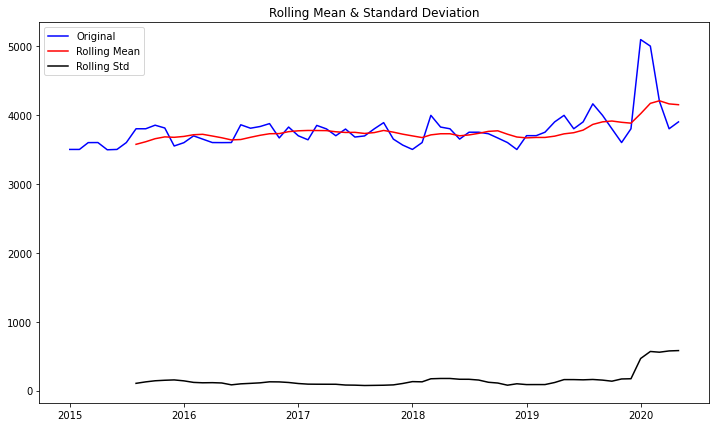

In [60]:
fig_roll_3br = plt.figure(figsize=(12,7))
plt.plot(agw_3br[['Greenpoint']], color='blue', label='Original')
plt.plot(roll_mean_g_3br, color='red', label='Rolling Mean')
plt.plot(roll_std_g_3br, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [61]:
#dickeyfuller test for Astoria Studios

dftest_g_3br = adfuller(agw_3br[['Sunnyside']])

# Extract and display test results in a user friendly manner
dfoutput_g_3br = pd.Series(dftest_g_3br[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_g_3br[4].items():
    dfoutput_g_3br['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_g_3br)

Results of Dickey-Fuller test: 

Test Statistic                 -3.815610
p-value                         0.002752
#Lags Used                      0.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [84]:
#stationary data

### ACF & PACF

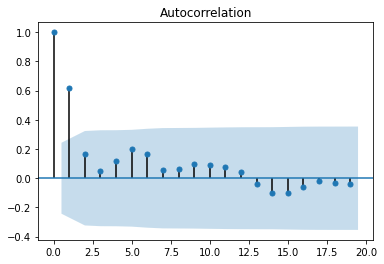

In [62]:
plot_acf(agw_3br['Greenpoint']);

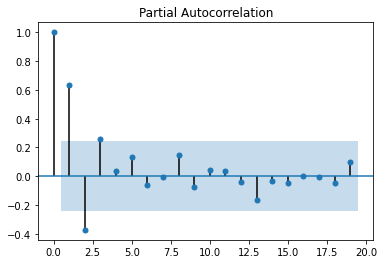

In [63]:
plot_pacf(agw_3br['Greenpoint']);

### BASELINE MODEL

In [64]:
g_3br = agw_3br[['Greenpoint']]

In [65]:
# Create lagged dataset
values_3br = pd.DataFrame(g_3br.values)
dataframe_3br = pd.concat([values_3br.shift(1), values_3br], axis=1)
dataframe_3br.columns = ['t-1', 't+1']
print(dataframe_3br.head(5))

    t-1   t+1
0   NaN  3500
1  3500  3500
2  3500  3599
3  3599  3600
4  3600  3495


In [66]:
# split into train and test sets
X_3br = dataframe_3br.values
train_size_3br = int(len(X_3br) * 0.75)
train_3br, test_3br = X_3br[1:train_size_3br], X_3br[train_size_3br:]
train_X_3br, train_y_3br = train_3br[:,0], train_3br[:,1]
test_X_3br, test_y_3br = test_3br[:,0], test_3br[:,1]

In [67]:
#model persistence defined above in studios

# walk-forward validation
predictions_3br = list()
for x in test_X_3br:
    yhat_3br = model_persistence(x)
    predictions_3br.append(yhat_3br)
test_score_3br = mean_squared_error(test_y_3br, predictions_3br)
print('Test RMSE: %.3f' % sqrt(test_score_3br))

Test RMSE: 408.229


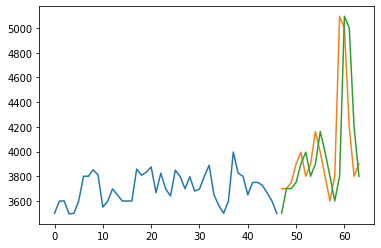

In [68]:
# plot predictions and expected results
plt.plot(train_y_3br)
plt.plot([None for i in train_y_3br] + [x for x in test_y_3br])
plt.plot([None for i in train_y_3br] + [x for x in predictions_3br])
plt.show()

In [85]:
#baseline score of 408

### ARIMA MODEL

predicted=3628.620873, expected=3700.000000
predicted=3628.620873, expected=3700.000000
predicted=3628.620873, expected=3750.000000
predicted=3628.620873, expected=3900.000000
predicted=3628.620873, expected=3995.000000
predicted=3628.620873, expected=3800.000000
predicted=3628.620873, expected=3900.000000
predicted=3628.620873, expected=4162.000000
predicted=3628.620873, expected=3995.000000
predicted=3628.620873, expected=3800.000000
predicted=3628.620873, expected=3600.000000
predicted=3628.620873, expected=3800.000000
predicted=3628.620873, expected=5095.000000
predicted=3628.620873, expected=5000.000000
predicted=3628.620873, expected=4200.000000
predicted=3628.620873, expected=3800.000000
predicted=3628.620873, expected=3900.000000
Test RMSE: 557.017


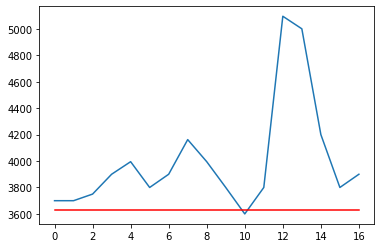

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   47
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -288.216
Method:                       css-mle   S.D. of innovations            107.712
Date:                Sun, 28 Jun 2020   AIC                            586.432
Time:                        12:08:08   BIC                            595.683
Sample:                             1   HQIC                           589.913
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8845      1.835      1.027      0.305      -1.713       5.482
ar.L1.D.y      0.5667      0.149      3.814      0.000       0.275       0.858
ar.L2.D.y     -0.1643      0.152     -1.078      0.2

In [74]:
#ARIMA model

X_rima_3br = agw_3br[['Greenpoint']].values
size_3br = int(len(X_rima_3br) * 0.75)
train_rima_3br, test_rima_3br = X_rima_3br[0:size], X_rima_3br[size:len(X_rima_3br)]
history_rima_3br = [x for x in train_rima_3br]
predictions_rima_3br = list()
for t in range(len(test_rima_3br)):
    model_3br = ARIMA(history_rima_3br, order=(2,1,1))
    model_fit_3br = model_3br.fit(disp=0)
    output = model_fit_3br.forecast()
    yhat = output[0]
    predictions_rima_3br.append(yhat)
    obs = test_rima_3br[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error_3br = mean_squared_error(test_rima_3br, predictions_rima_3br)
print('Test RMSE: %.3f' % sqrt(error_3br))
# plot
plt.plot(test_rima_3br)
plt.plot(predictions_rima_3br, color='red')
plt.show()
print(model_fit_3br.summary())

In [ ]:
#557 ARIMA score, higher than base

## FB PROPHET

In [76]:
fb_g_3br = g_3br

In [77]:
fb_g_3br.reset_index(inplace=True)
fb_g_3br.index.rename('', inplace=True)
fb_g_3br.rename(columns={'index': 'ds', 'Greenpoint': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [78]:
fb_g_3br.head(1)

areaName,ds,y
,,
0,2015-01-01,3500


In [79]:
# Train/Split

X_g_3br = fb_g_3br['ds'].values
y_g_3br = fb_g_3br['y'].values

X_train_3br = X_g_3br[:int(X_g_3br.shape[0]*0.75)]
X_test_3br = X_g_3br[int(X_g_3br.shape[0]*0.75):]
y_train_3br = y_g_3br[:int(X_g_3br.shape[0]*0.75)]
y_test_3br = y_g_3br[int(X_g_3br.shape[0]*0.75):]

g_3br_train = pd.DataFrame(y_train_3br,index = X_train_3br, columns = ['y'])
g_3br_test = pd.DataFrame(y_test_3br, index = X_test_3br, columns = ['y'])
g_3br_train.head()
g_3br_train.reset_index(inplace = True)
g_3br_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  597.4126164557956


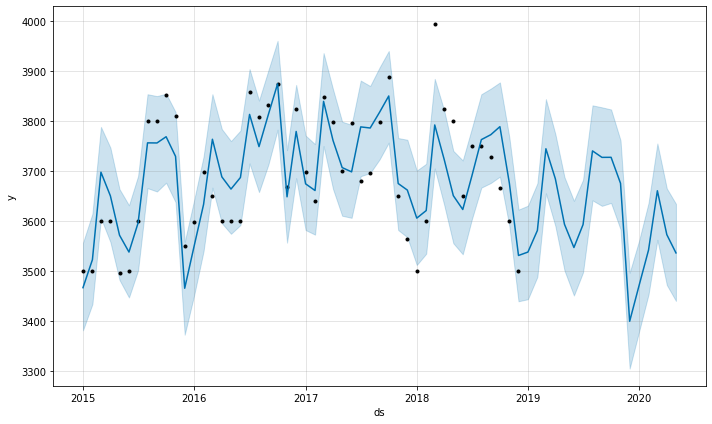

In [80]:
g_3br_prophet = Prophet().fit(g_3br_train)

future_g_3br = g_3br_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_g_3br = g_3br_prophet.predict(future_g_3br)
forecast_g_3br.tail()

fig1_g_3br = g_3br_prophet.plot(forecast_g_3br)

preds_g_3br = forecast_g_3br[48:][['ds','yhat']].set_index('ds')
preds_g_3br.head()

preds_g_3br_df = pd.concat([g_3br_test ,preds_g_3br],axis = 1)
preds_g_3br_df.head()

error_prophet_3br = np.sqrt(sum((preds_g_3br_df['y'] - preds_g_3br_df['yhat'])**2)/len(preds_g_3br_df))
print('RMSE in $$: ', error_prophet_3br)


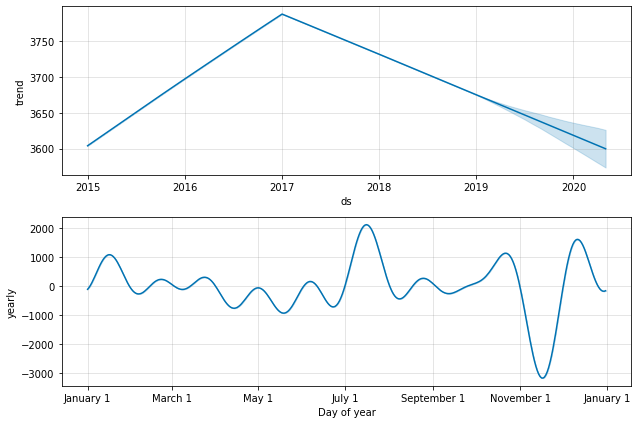

In [81]:
fig3_g_3br = g_3br_prophet.plot_components(forecast_g_3br)

In [ ]:
#597 FP Prophet score, higher than both base and ARIMA